In [10]:
import os
import sys
from pathlib import Path

cwd = Path(os.getcwd())
sys.path.append(str(cwd.parent)+'/src/')

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import itertools

from IPython import display
import matplotlib.pyplot as plt

import geometric_objects as geomObj

In [5]:
def sphere(phi:float,theta:float,R:float=1.0):
    x, y, z = R*np.sin(theta)*np.cos(phi), R*np.sin(theta)*np.sin(phi), R*np.cos(theta)
    return x,y,z

def cylinder(phi:float,z:float,R:float=1):
    X, Y, Z = R*np.cos(phi), R*np.sin(phi), R*z
    return X, Y, Z

def fit_quadratic_surf(x,y,z): # FITS SURFACE z(x,y) = ax**2 + by**2 + c xy + dx + ey + f => b = A  where A = {x**2, y**2, xy, x, y, 1} = (1,5) matrix and v = {a,b,c,d,e,f} = (5,1) matrix 
    A = np.c_[x**2,y**2,x*y,x,y,np.ones_like(x)] # STACKS COMPONENTS (x**2, y**2 etc.) AS VECTORS (VECTORISATION) HORIZONTALLY (APPOSED TO VSTACK) - EACH COLUMN REPRESENTS TERMS x**2, y**2, xy, etc
    sol, _, _, _ = np.linalg.lstsq(A,z,rcond=None) # LEAST SQUARE FIT OF LINEAR EQN A v = b ; rcond = CUT OFF CONDITION

    return sol

def estimate_principal_curvatures(point,neighbors):

    # COMPUTE NORMAL AND TANGENT FRAME
    normal, e1, e2 = pca_analysis(point, neighbors)

    # CENTER NBRS
    nbrs = neighbors - point

    # PROJECT NBRS TO TANGENT PLANE
    x = nbrs @ e1
    y = nbrs @ e2
    z = nbrs @ (-normal) # PROJECTION TO NORMAL - USE -normal SINCE normal POINTS OUTWARD THEN z(x,y) APPROXIMATES SURFACE IN OPPOSITE DIRECTION

    # FIT QUADARTIC SURFACE
    a, b, c, _, _, _ = fit_quadratic_surf(x,y,z)

    # COMPUTE PRINCIPAL CURVATURES
    Hess = np.array([[2*a, c], [c, 2*b]])

    kappa1, kappa2 = np.linalg.eigvals(Hess)

    return kappa1, kappa2

def mean_curv(cloud,k:int=15):
    H_ = []

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(cloud)
    _, indices = nbrs.kneighbors(cloud)

    for n in range(indices.shape[0]):
        point = cloud[n] 
        
        neighbours = cloud[indices[n]]

        kappa1, kappa2 = estimate_principal_curvatures(point, neighbours)

        H_.append((point,(kappa1 + kappa2) / 2))

    return H_
        
def plot_nbrhd(cloud,idx,k:int=15):
  
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(cloud)
    _, indices = nbrs.kneighbors(cloud)

    point = cloud[idx]
    neighbours = cloud[indices[idx]]

    normal, _, _ = pca_analysis(point, neighbours)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], color='blue', alpha=0.1)
    ax.scatter(neighbours[:, 0], neighbours[:, 1], neighbours[:, 2], color='red', s=10) # NBRS OF p
    ax.scatter(point[0], point[1], point[2], color='green', s=20)  # p

    # PLOT NORMAL AS ARROW 
    ax.quiver(
        point[0], point[1], point[2], # START POINT OF VECTOR
        normal[0] , normal[1], normal[2], # DIRECTION
        color = 'red', alpha = 1, lw = 2,
    )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.tight_layout()
    plt.show()
    

def plot_surf(surf):
    """
    vertices = list of np.arrays = pts
    """
    
    vertices_ = np.array(surf[0])

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(vertices_[:, 0], vertices_[:, 1], vertices_[:, 2], color='blue')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    plt.tight_layout()
    plt.show()



In [6]:
class Icosphere():
    
    def __init__(self,n_subdivision:int = None):

        # ICOSPHERE
        phi__ = (1 + np.sqrt(5)) / 2    # GOLDEN RATIO

        # VERTICES: 
        vertices_ = np.array([])

        for eps1 in [1.,-1.]:
            for eps2 in [1.,-1.]:
                vertices_ = np.append(vertices_,[0,eps1*1,eps2*phi__])
                vertices_ = np.append(vertices_,[eps1*1,eps2*phi__,0])
                vertices_ = np.append(vertices_,[eps2*phi__,0,eps1*1])

        vertices_ = vertices_.reshape(-1,3)

        # NORMALISE vertices_
        vertices_ /= np.linalg.norm(vertices_, axis=1)[:, np.newaxis]

        # CONVERT TO LIST
        vertices_ = list(vertices_)

        edges_, faces_ = EF(vertices_)

        self.surf = (vertices_, edges_, faces_)

        if n_subdivision:
            for n in range(n_subdivision):
                self.subdivision()

    def subdivision(self):
        self.surf = subdivide_triangular_mesh(self.surf)

    def plot_surface(self):
            vertices_ = self.get_vertices()

            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(projection='3d')

            ax.scatter(vertices_[:, 0], vertices_[:, 1], vertices_[:, 2], color='blue')

            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
        
            plt.show()

    def get_vertices(self,as_array:bool = False):
        if as_array:
            return np.array(self.surf[0])
        else:
            return self.surf[0]
    
    def get_edges(self):
        return self.surf[1]
    
    def get_faces(self):
        return self.surf[2]
    
    def get_idx(self,v):
        vertices_ = self.get_vertices()
        for i, u in enumerate(vertices_):
            if np.array_equal(u, v):  
                return i
        return None  # RETURN None IF NOT FOUND
    
    def get_neighbours(self,v):
        vertices_ = self.get_vertices()
        edges_ = self.get_edges() 
        v_idx = self.get_idx(v)
        
        neighbours = np.array([ vertices_[nbr_idx] for u_idx, nbr_idx in edges_ if u_idx == v_idx])

        return neighbours


    def get_normal(self,v):
        # neighbours = self.get_neighbours(v)
        vertices_ = self.get_vertices(as_array=True)

        nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vertices_)
        _, indices = nbrs.kneighbors([v])

        neighbours = vertices_[indices.flatten()]

        normal_, _, _ = pca_analysis(v, neighbours)

        return normal_
    
    def plot_normals(self,scale:float=1.):

        vertices_ = self.get_vertices()
        vertices_as_arr_ = np.array(vertices_)

        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(projection='3d')

        ax.scatter(vertices_as_arr_[:,0], vertices_as_arr_[:, 1], vertices_as_arr_[:, 2], color='blue')

        for v in vertices_:
            # PLOT NORMAL AS ARROW 
            normal_ = scale*self.get_normal(v)
            ax.quiver(
                v[0], v[1], v[2], # START POINT OF VECTOR
                normal_[0] , normal_[1], normal_[2], # DIRECTION
                color = 'black', alpha = 0.8, lw = 1,
            )


        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        plt.show()


class Cylinder():
     
     def __init__(self,n_points:int=10,R:float=1.0):

        # UNIFORM RECTANGULAR GRID OF [0,2PI] X [0,1] 
        steps_ = n_points
        step_size_ = 1 / steps_

        phi_ = np.arange(0,2*np.pi + step_size_,step_size_)
        z_ = np.arange(0,1 + step_size_,step_size_)

        phi_,z_  = np.meshgrid(phi_,z_)

        # MAP TO CYLINDER
        X_, Y_,Z_ = R*np.cos(phi_), R*np.sin(phi_), R*z_  

        vertices_ = np.array([X_.ravel(),Y_.ravel(),Z_.ravel()]).T
        
     

In [11]:
icosphere = geomObj.Icosphere(n_subdivision=2)
cylinder = geomObj.Cylinder()

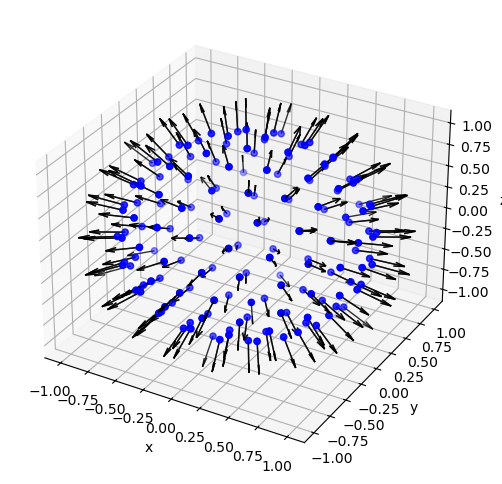

In [6]:
icosphere.plot_normals(scale=0.3)

In [155]:
np.array([np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])])[0,1]

0

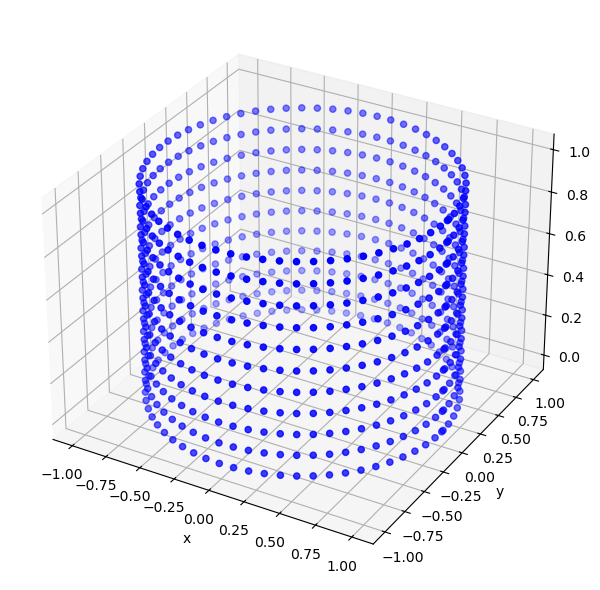

In [61]:
plot_surf((foo,1,2))

Note: uniform sampling done by uniform sampling the rectangle $[0,2\pi] \times [0,1] $ in $\mathbb{R}^2$ and then rolling it up (via prametrisation) into a cylinder.

It would be interesting to try out other uniform grids, for example honeycone!

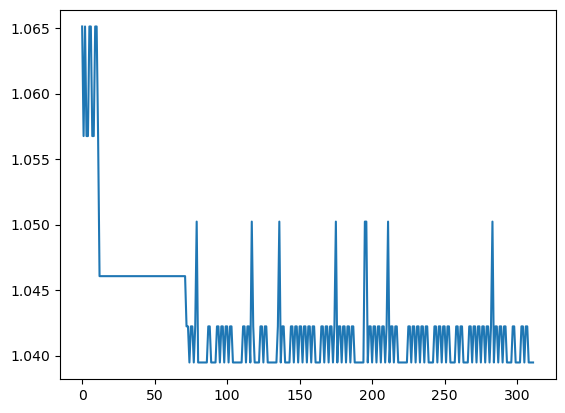

In [42]:
# EXAMPLE SPHERE

# phi = np.linspace(0,2*np.pi,50)
# theta = np.linspace(0,np.pi,50)

# steps = 10
# step_size = 1 / steps

# phi = np.arange(0.1,2*np.pi + step_size,step_size)
# theta = np.arange(0.1,np.pi + step_size,step_size)

# phi, theta = np.meshgrid(phi,theta)

# X,Y,Z = sphere(phi,theta)

# S2 = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T

icosphere = Icosphere(n_subdivision=2)

S2 = np.array(icosphere.surf[0])

curv = mean_curv(S2,k=15)

H = np.array([F for _, F in curv])

plt.plot(H)
plt.show()


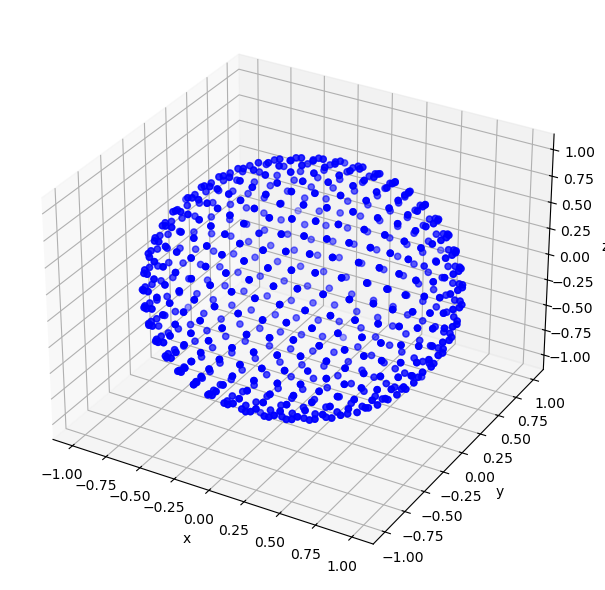

In [31]:
icosphere.plot()

In [41]:
Y.shape

(11, 64)

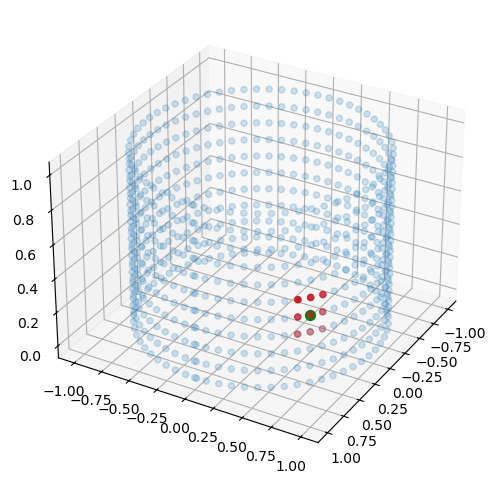

In [36]:
# NEIGHBORHOOD OF POINT

# UNIFORM RECTANGULAR GRID OF [0,2PI] X [0,1] 
steps = 10
step_size = 1 / steps
phi = np.arange(0,2*np.pi + step_size,step_size)
z = np.arange(0,1 + step_size,step_size)

phi,z  = np.meshgrid(phi,z)

# DEFINE CLOUD OF POINTS
points = np.array([phi.ravel(),z.ravel()]).T


# COMPUTE KNN INSIDE THE RECTANGLE
k = 9

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points)
distances, indices = nbrs.kneighbors(points)

n = 265

neighbors = points[indices[n]]
point = points[n]

# MAP TO CYLINDER
X,Y,Z = cylinder(phi,z)                                 # cloud of points on cylinder
pX,pY,pZ = cylinder(point[0],point[1])                  # fixed point p
nX, nY, nZ = cylinder(neighbors[:,0],neighbors[:,1])    # neighbours of p 


# PLOT
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X,Y,Z,alpha=0.2)
ax.scatter(nX,nY,nZ,color='r')
ax.scatter(pX,pY,pZ,color='g',s=50)

ax.view_init(elev=30, azim=30, roll=0)

plt.show()

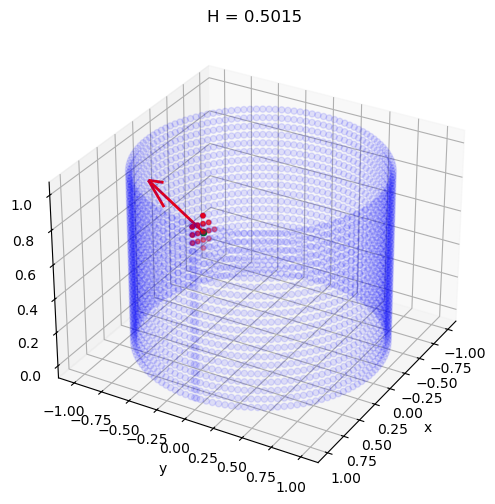

KeyboardInterrupt: 

In [9]:
# "VIDEO" NORMAL VECTOR MOVING AROUND CYLINDER AND MEAN CURVATURE

# UNIFORM RECTANGULAR GRID OF [0,2PI] X [0,1] 
steps = 20
step_size = 1 / steps
phi = np.arange(0,2*np.pi + step_size,step_size)
z = np.arange(0,1 + step_size,step_size)

phi,z  = np.meshgrid(phi,z)

# CLOUD OF POINTS
points = np.array([phi.ravel(),z.ravel()]).T

# MAP TO CYLINDER
X,Y,Z = cylinder(phi,z)  # cloud of points on cylinder 

# COMPUTE KNN INSIDE THE RECTANGLE
k = 15

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points)
distances, indices = nbrs.kneighbors(points)

# CLOUD OF POINTS ON CYLINDER (UNIFORM)
XYZ = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T 

for i in range(0,100):
    n = 800 + 3*i # "VIDEO FRAME"

    neighbors = points[indices[n]]
    point = points[n]                   

    pX,pY,pZ = cylinder(point[0],point[1])                  # fixed point p             
    nX, nY, nZ = cylinder(neighbors[:,0],neighbors[:,1])    # neighbours of p 
    
    point_on_cyl = np.array([pX,pY,pZ])
    neighbors_on_cyl = np.vstack([nX,nY,nZ]).T

    normal, e1, e2 = pca_analysis(point_on_cyl, neighbors_on_cyl)

    kappa1, kappa2 = estimate_principal_curvatures(point_on_cyl, neighbors_on_cyl)

    H = (kappa1 + kappa2) / 2 # kappa1 = 0, kappa2 = 1 / (2R)
    

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], color='blue', alpha=0.1)
    ax.scatter(neighbors_on_cyl[:, 0], neighbors_on_cyl[:, 1], neighbors_on_cyl[:, 2], color='red', s=10) # NBRS OF p
    ax.scatter(pX, pY, pZ, color='green', s=20)  # p

    # PLOT NORMAL AS ARROW 
    ax.quiver(
        pX, pY, pZ, # START POINT OF VECTOR
        normal[0] , normal[1], normal[2], # DIRECTION
        color = 'red', alpha = 1, lw = 2,
    )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'H = {H:.4f}')

    ax.view_init(elev=30, azim=30, roll=0)


    display.display(plt.gcf())
    display.clear_output(wait=True)

    plt.show()



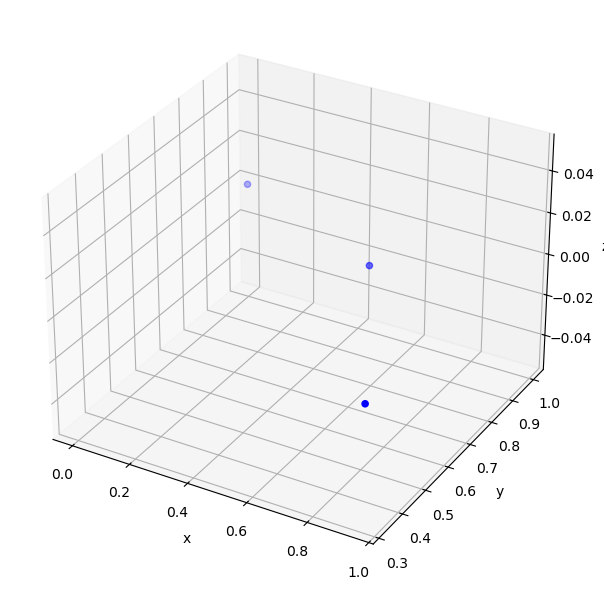

triangle before subdivision
|V| = 3
|E| = 3
|F| = 1
Euler = 1


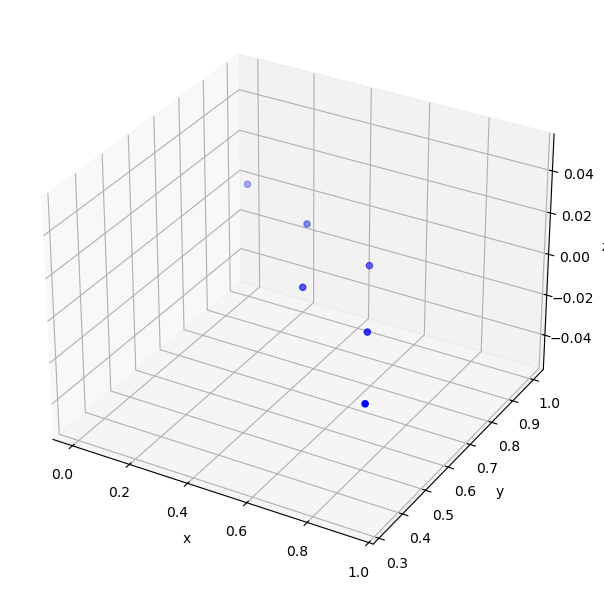


triangle after 1st subdivision
|V| = 6
|E| = 9
|F| = 4
Euler = 1


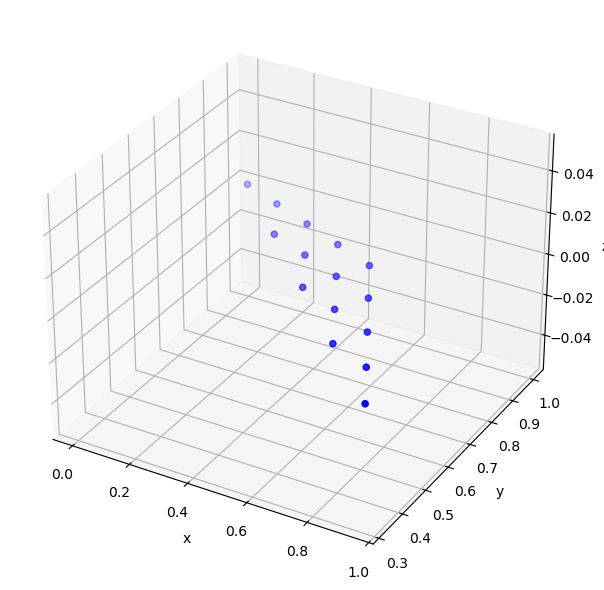


triangle after 2nd subdivision
|V| = 15
|E| = 30
|F| = 16
Euler = 1


In [539]:
V = [np.array([np.sin(0),np.cos(0),0]),np.array([np.sin(120),np.cos(120),0]),np.array([np.sin(240),np.cos(240),0])]
E = {(0,1),(0,2),(1,2)}
F = {(0,1,2)}


triangle = (V,E,F)
plot_surf(V)

print('triangle before subdivision')
print(f'|V| = {len(V)}')
print(f'|E| = {len(E)}')
print(f'|F| = {len(F)}')
print(f'Euler = {len(V)-len(E)+len(F)}')


V, E, F = subdivide(triangle)
plot_surf(V)

print('\ntriangle after 1st subdivision')
print(f'|V| = {len(V)}')
print(f'|E| = {len(E)}')
print(f'|F| = {len(F)}')
print(f'Euler = {len(V)-len(E)+len(F)}')

V, E, F = subdivide((V,E,F))
plot_surf(V)

print('\ntriangle after 2nd subdivision')
print(f'|V| = {len(V)}')
print(f'|E| = {len(E)}')
print(f'|F| = {len(F)}')
print(f'Euler = {len(V)-len(E)+len(F)}')

(2, 4, 6)


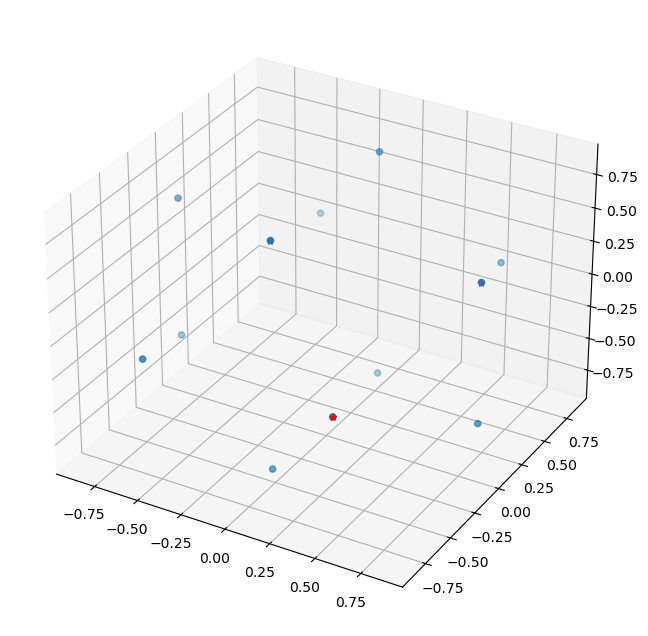

In [308]:
# PLOT

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(vertices)
distances, indices = nbrs.kneighbors(vertices)

face = list(faces)[-1]

f0 = vertices[face[0]]
f1 = vertices[face[1]]
f2 = vertices[face[2]]

n = 6
v = vertices[n,:]
nvs = vertices[indices[n],:]

print(face)

ax.scatter(vertices[:,0],vertices[:,1],vertices[:,2],'ko')
# ax.scatter(v[0],v[1],v[2],marker='o',color='green',s=40)
# ax.scatter(nvs[1:,0],nvs[1:,1],nvs[1:,2],color='red',s=20)
ax.scatter(f0[0],f0[1],f0[2],marker='*',color='red')
ax.scatter(f1[0],f1[1],f1[2],marker='*',color='red')
ax.scatter(f2[0],f2[1],f2[2],marker='*',color='red')

plt.show()